# Predicting cloud cover using Linear regression

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from utils import mean_squared_error, r2_score, A_R2, NRMSE, transforming_predictorspace, standardicing_responce, train_test_split
#%matplotlib notebook

from sklearn.preprocessing import StandardScaler

In [2]:
def logit_inv(x): 
    return np.exp(x)/(1 + np.exp(x))

def logit(x):
    return np.log(x+1e-12) - np.log(1+1e-12-x)

def standardicing_responce(y):
    return (y-np.mean(y))/np.std(y)

# Reading in the data

In [3]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

In [4]:
tcc = cloud.variables["tcc"][:][:][:].data
rel = relative.variables["r"][:][:][:][:].data
spe = specific.variables["q"][:][:][:][:].data
surf_pre = pressure.variables["sp"][:][:][:].data
temp = temperature.variables["t2m"][:][:][:].data

In [5]:
rel.shape

(32, 6, 61, 77)

In [6]:
temp.shape

(32, 61, 77)

In [7]:
# Choosing the number of days for training and testing.

In [8]:
# for one certain timestep 

n_days = 7

TCC = []
REL = []
SPE = []
PRE = []
TEMP = []


for t in range(n_days*4):
    TCC.append(tcc[t][:][:].flatten())
    #print(rel[t][0].flatten().shape)
    REL.append(rel[t][0][:][:].flatten())
    SPE.append(spe[t][0][:][:].flatten())
    PRE.append(surf_pre[t][:][:].flatten())
    TEMP.append(temp[t][:][:].flatten())


In [9]:
y =(np.array(TCC).flatten())
temp = y[y<1]
#y[y>1] = temp.max()
#X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
#y = logit(np.array(TCC).flatten())

In [10]:
# Need to determine the largest number smaller than zero to swap all elements larger than one with this...
temp.max()

0.9999694810258271

In [11]:
y[y>1] = temp.max()

In [12]:
X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
y = logit(np.array(TCC).flatten())

In [13]:
y.shape

(131516,)

In [14]:
X[0].shape, X[1].shape ,X[2].shape, X[3].shape

((131516,), (131516,), (131516,), (131516,))

In [15]:
X = X.transpose()

In [16]:
X.shape

(131516, 4)

In [17]:
y.max(), y.min()

(36.04365338911915, -26.93794050959591)


# Regression analysis combined with applying a logit transformation.

In [18]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}

param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2, feature_scale = False
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
3


In [19]:
coeffs["lasso"]

[[array([ 4.83541040e-01, -1.49676460e+03,  2.57965826e-05,  1.54448509e-01]),
  array([ 2.51916351e-02, -0.00000000e+00,  4.63404493e-06, -1.64713918e-02]),
  array([ 2.51819007e-02, -0.00000000e+00,  4.57738678e-06, -1.63140113e-02]),
  array([ 2.50845468e-02, -0.00000000e+00,  4.01082120e-06, -1.47402153e-02]),
  array([ 2.39112751e-02, -0.00000000e+00, -1.19702681e-06, -0.00000000e+00]),
  array([ 0.00000000e+00, -0.00000000e+00, -5.30376707e-06, -0.00000000e+00]),
  array([ 0., -0., -0., -0.]),
  array([ 0., -0., -0., -0.]),
  array([ 0., -0., -0., -0.]),
  array([ 0., -0., -0., -0.])]]

In [20]:
results["mse_test"]["lasso"]

[[1.3607696512954144,
  1.1935419263075417,
  1.1933263070704312,
  1.1914992700991653,
  1.225810816597163,
  2.087006241435186,
  nan,
  nan,
  nan,
  nan]]

In [21]:
results.keys()

dict_keys(['mse_test', 'mse_train', 'r2_test', 'r2_train'])

In [22]:
results["r2_test"]["ridge"]

[[-0.3627915261377852,
  -0.18388201157805883,
  -0.18319835662460182,
  -0.17873549299657387,
  -0.17480276606895417,
  -0.17640025138250492,
  -0.17675959538412078,
  -0.1767986026961148,
  -0.17680425811869926,
  -0.17682207493578406]]

In [23]:
results["r2_test"]["ols"]

[[-0.35696947165598636]]

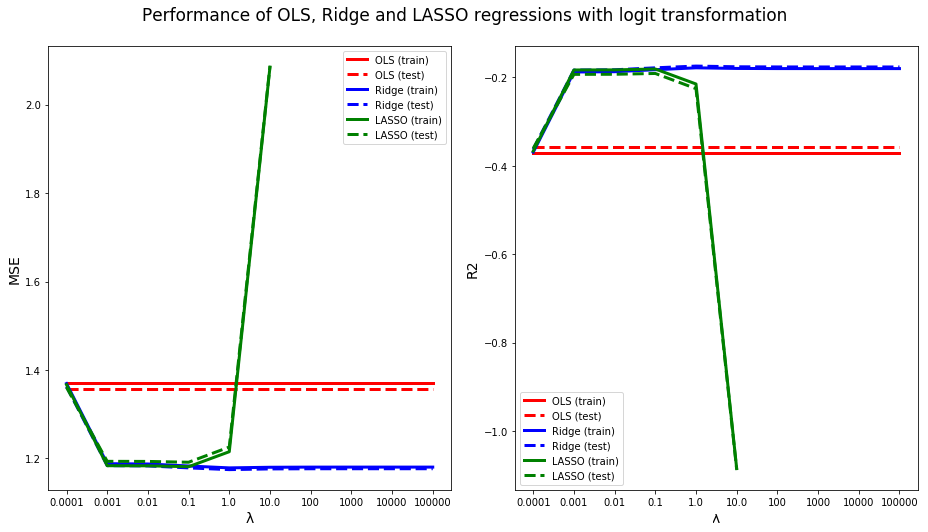

In [24]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions with logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_with_Logit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Regression analysis without any transformation, cloud cover fractions \in [0,1]

In [25]:
y = logit_inv(y) #transforming the data back. 

results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


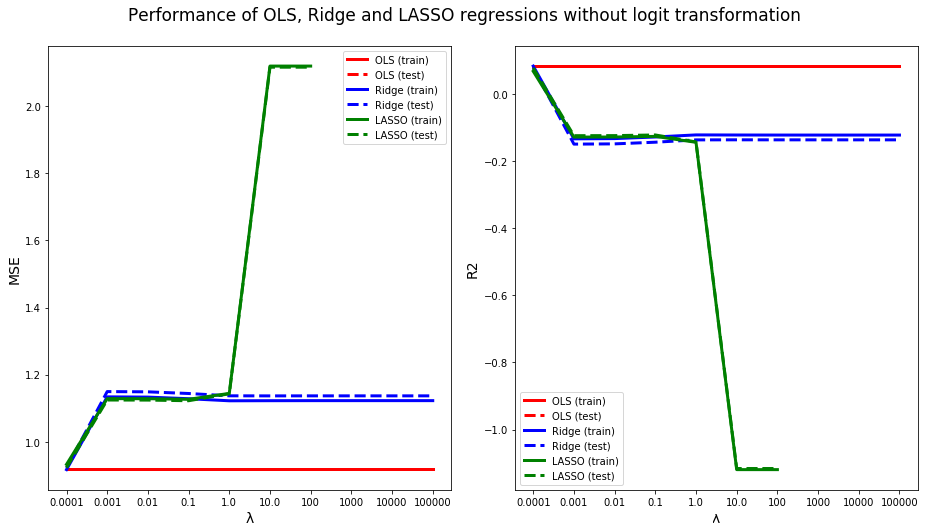

In [26]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions without logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_withoutLogit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Determining which feature is most important

## Results:

# Bias and variance discussion 

In [27]:
# Experimental setup
models = {
    "ols": algorithms.OLS, 
    "ridge": algorithms.Ridge, 
    "lasso": algorithms.Lasso, 
}

lmd = {
    'ols': [0],
    'lasso': [0.001],
    'ridge':[0.001]
    
}
nboots = 100

z_test, z_pred_test, bias, var, beta, mse_test, mse_train, ci_beta = resample(models, lmd, X, y, nboots, split_size = 0.2)

ci_beta.shape

(2, 4)

In [28]:
ci_beta.shape # Muligens ikke så mys vits med konfidenseintervall av disse dimensjoner. 

(2, 4)

In [29]:
bias

{'ridge': 0.09466480292067736,
 'lasso': 0.09577863742129802,
 'ols': 0.09466601995640592}

In [30]:
var # variance dominates because we don't have so mush data???

{'ridge': 3.624209891666375e-06,
 'lasso': 3.935863199490351e-06,
 'ols': 3.47458100485581e-06}

In [31]:
mse_test

{'ridge': 0.09466842713056901,
 'lasso': 0.09578257328449753,
 'ols': 0.09466949453741079}

In [32]:
bias["ols"] + var["ols"] 

0.09466949453741078

In [33]:
bias["ridge"] + var["ridge"] 

0.09466842713056903

In [34]:
bias["lasso"] + var["lasso"] 

0.09578257328449752

The bias and variance summes to the mse of the ols model.

In [35]:
#logit_inv(z_pred_best["lasso"])

# Compare with scikit learn without logit

In [36]:
y = logit_inv(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
p = model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

p = standardicing_responce(transforming_predictorspace(p))
y_test = standardicing_responce(y_test)

mean_squared_error(p, y_test)

0.9026612400414826

In [38]:
model.coef_

array([ 3.59331370e-03, -1.64730953e+01,  1.44731271e-06,  3.04075763e-03])

In [39]:
# relative humidity, specific humidity, pressure, temprature

# With logit transformation

In [40]:
y

array([0.73105258, 0.73105258, 0.73105858, ..., 0.51903464, 0.55011499,
       0.62107592])

In [41]:
y = logit(y)

In [42]:
y.min(), y.max()

(1.999511667349907e-12, 0.9999999999976487)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = LinearRegression()
model.fit(X_train, y_train)
p = model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

p = standardicing_responce(transforming_predictorspace(p))
y_test = standardicing_responce(y_test)

mean_squared_error(p, y_test)


0.9041869821473925

In [44]:
X_b = logit_inv(p)
y_b = logit_inv(y_test)
n,p = np.shape(X_train)
print(n,p)
A_R2(X_b, y_b ,n, p)

105213 4


0.055707078941135135

In [45]:
model.coef_

array([ 1.56497232e-02, -7.42122431e+01,  6.20688367e-06,  1.33323358e-02])

In [46]:
# relative humidity, specific humidity, pressure, temprature

# Linear regression using standard scaler

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
scaler = StandardScaler()
fit = scaler.fit(X_train)
X_test = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105213, 4), (105213, 4), (105213,), (26303,))

In [49]:
y

array([0.99996948, 0.99996948, 1.        , ..., 0.07617536, 0.20113531,
       0.49411747])

In [50]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X_train, y_train, split_size=0.2, feature_scale = True,
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


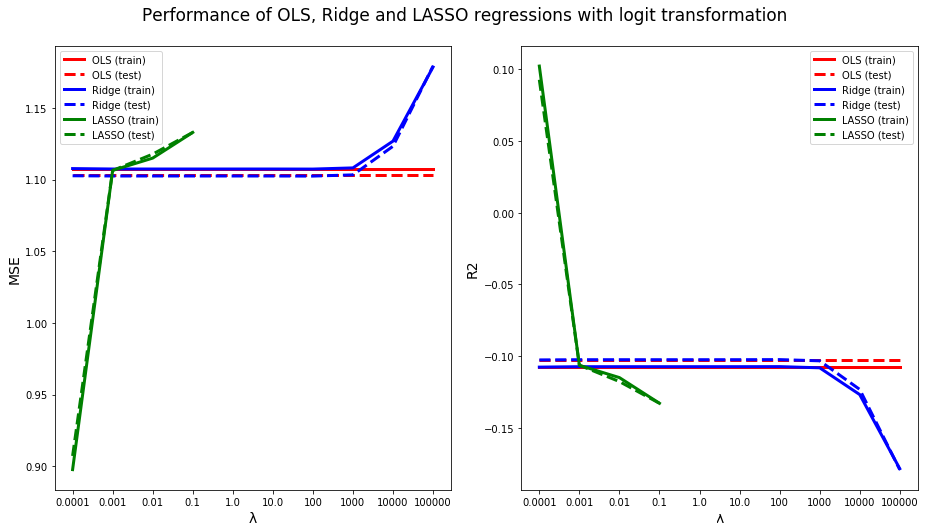

In [51]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions with logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_with_Logit_StandardScaler.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()